In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import interpolate
import math
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import Rbf

In [2]:
x_i = 196
y_j = 128
number = x_i*y_j
file_name = '/home/haoyan/Desktop/ML-CFD/CASE/PHill/LES_nasa_PHill/hill_LES_avgresults.dat'
raw_data = []

In [3]:
def data_r_o(file_name, i, j):#input (file_name, number of grids in x-direction, number of grids in y-direction)
    number = i * j
    raw_data = []
    with open(file_name) as f:
        for line in f:
            word_list = line.split()
            for i in word_list:
                raw_data.append(float(i))
    raw_data = np.array(raw_data)
    x = raw_data[0:number]
    y = raw_data[number:number*2]
    x = x * 28
    y = y * 28
    p = raw_data[number*2:number*3]
    u = raw_data[number*3:number*4]
    v = raw_data[number*4:number*5]
    w = raw_data[number*5:number*6]
    nut = raw_data[number*6:number*7]
    uu = raw_data[number*7:number*8]
    vv = raw_data[number*8:number*9]
    ww = raw_data[number*9:number*10]
    uv = raw_data[number*10:number*11]
    uw = raw_data[number*11:number*12]
    vw = raw_data[number*12:number*13]
    k = raw_data[number*13:number*14]
    return x,y,p,u,v,w,nut,uu,vv,ww,uv,uw,vw,k 

def add_boundary_values(uu,x_i,y_j):
    uu_add = np.zeros(((y_j+2),(x_i+2)))
    for i in range(y_j):
        uu_add[i+1][1:-1] = uu[(x_i*i):(x_i*(i+1))]
    uu_add[0] = uu_add[1]
    uu_add[-1] = uu_add[-2]
    uu_add[:,0] = uu_add[:,1]
    uu_add[:,-1] = uu_add[:,-2]
    uu_add = np.reshape(uu_add,(x_i+2)*(y_j+2))
    return uu_add

def add_boundary_x(uu,x_i,y_j):
    uu_add = np.zeros(((y_j+2),(x_i+2)))
    for i in range(y_j):
        uu_add[i+1][1:-1] = uu[(x_i*i):(x_i*(i+1))]
    uu_add[0] = uu_add[1]
    uu_add[-1] = uu_add[-2]
    uu_add[:,0] = 0
    uu_add[:,-1] = 252
    uu_add = np.reshape(uu_add,(x_i+2)*(y_j+2))
    return uu_add

def low_shape(x):
    y = 0.
    if x > 198:
        x = 252 - x
    if x >=0 and x <= 9:
        y = min(28.,2.800000000000E+01 + 0.000000000000E+00*x + 6.775070969851E-03*(x**2) - 2.124527775800E-03*(x**3)) 
    elif x > 9 and x <= 14:
        y = 2.507355893131E+01 + 9.754803562315E-01*x - 1.016116352781E-01*(x**2) + 1.889794677828E-03*(x**3)
    elif x > 14 and x <= 20:
        y = 2.579601052357E+01 + 8.206693007457E-01*x - 9.055370274339E-02*(x**2) + 1.626510569859E-03*(x**3)
    elif x > 20 and x <= 30:
        y = 4.046435022819E+01 - 1.379581654948E+00*x + 1.945884504128E-02*(x**2) - 2.070318932190E-04*(x**3)
    elif x > 30 and x <= 40:
        y = 1.792461334664E+01 + 8.743920332081E-01*x - 5.567361123058E-02*(x**2) + 6.277731764683E-04*(x**3)
    elif x > 40 and x <= 54:
        y = max(0.,5.639011190988E+01 - 2.010520359035E+00*x + 1.644919857549E-02*(x**2)  +2.674976141766E-05*(x**3))
    return y

def add_boundary_y(uu,x_add,x_i,y_j):
    uu_add = np.zeros(((y_j+2),(x_i+2)))
    for i in range(y_j):
        uu_add[i+1][1:-1] = uu[(x_i*i):(x_i*(i+1))]
    uu_add[:,0] = uu_add[:,1]
    uu_add[:,-1] = uu_add[:,-2]
    uu_add[-1] = 3.035 * 28
    uu_add[0][0] = 28
    uu_add[0][-1] = 28
    for i in range(x_i):
        uu_add[0][i+1] = low_shape(x_add[i+1])
    uu_add = np.reshape(uu_add,(x_i+2)*(y_j+2))
    return uu_add

def Cal_anisotropy(uu,uv,uw,vv,vw,ww,k):
    B_11 = np.zeros(len(uu))
    B_22 = np.zeros(len(uu))
    B_33 = np.zeros(len(uu))
    B_12 = np.zeros(len(uu))
    B_13 = np.zeros(len(uu))
    B_23 = np.zeros(len(uu))
    for i in range(len(uu)):
        B_11[i] = uu[i]/(2*k[i]) - 1/3
        B_12[i] = uv[i]/(2*k[i]) 
        #B_13[i] = uw[i]/(2*k[i]) Not needed for two-dimensional cases
        B_22[i] = vv[i]/(2*k[i]) - 1/3
        #B_23[i] = vw[i]/(2*k[i])
        B_33[i] = ww[i]/(2*k[i]) - 1/3
    return B_11,B_12,B_13,B_22,B_23,B_33

def reading_field(head,name,n_package,file_name,i,j):#Reading the raw vector data
    file = head +name +'/'+ n_package + '/' + file_name
    raw_data = []
    number = 23 + (i * j)
    with open(file) as f:
        for line in f:
            line = line.strip('\n')
            raw_data.append(line)
    data_str = (raw_data[23:number])
    data  = [float(i) for i in data_str]
    data = np.array(data)
    return data


def plot_contour_2(x_coordinate,y_coordinate,i,j,field,field_name,bar_numbers,Min,Max):
    X = np.zeros((j,i))
    Y = np.zeros((j,i))
    Field = np.zeros((j,i))
    for n in range(j):
        X[n,:] = x_coordinate[i*n:i*(n+1)]
        Y[n,:] = y_coordinate[i*n:i*(n+1)]
        Field[n,:] = field[i*n:i*(n+1)]
    fig,ax = plt.subplots(figsize=(20,7.5))
    levels = list(np.linspace(Min,Max,bar_numbers))
    p1 = ax.contourf(X,Y,Field,levels,cmap=cm.jet,extend='both')
    p2 = ax.contour(X,Y,Field,levels,linewidths=0.5,colors='black',extend='both')
    ax.set_xlim(min(x_coordinate), max(x_coordinate))
    ax.set_ylim(min(y_coordinate), max(y_coordinate))
    ax.set_xlabel("$\t{x}$(mm)",size=15)
    ax.set_ylabel("$\t{y}$(mm)",size=15)
    cbar = fig.colorbar(p1)
    cbar.set_label(field_name, size=18)
    plt.show()
    return 0

In [4]:
x,y,p,U,V,W,nut,uu,vv,ww,uv,uw,vw,k = data_r_o(file_name,x_i,y_j)
#uu_add = add_boundary_values(uu,x_i,y_j)
#uv_add = add_boundary_values(uv,x_i,y_j)
#uw_add = add_boundary_values(uw,x_i,y_j)
#vv_add = add_boundary_values(vv,x_i,y_j)
#vw_add = add_boundary_values(vw,x_i,y_j)
#ww_add = add_boundary_values(ww,x_i,y_j)
#k_add = add_boundary_values(k,x_i,y_j)
x_add = add_boundary_x(x,x_i,y_j)
y_add = add_boundary_y(y,x_add,x_i,y_j)

In [5]:
b_11, b_12, b_13, b_22, b_23, b_33 = Cal_anisotropy(uu, uv, uw, vv, vw, ww, k)
b_11_add = add_boundary_values(b_11,x_i,y_j)
b_12_add = add_boundary_values(b_12,x_i,y_j)
b_13_add = add_boundary_values(b_13,x_i,y_j)
b_22_add = add_boundary_values(b_22,x_i,y_j)
b_23_add = add_boundary_values(b_23,x_i,y_j)
b_33_add = add_boundary_values(b_33,x_i,y_j)

In [6]:
x_add = x_add / 28
y_add = y_add / 28
head ='/home/haoyan/Desktop/ML-CFD/CASE/PHill/Grid-iretation-independency/'
x_RANS = reading_field(head,'h10','0','Cx',140,150)*1000/28
y_RANS = reading_field(head,'h10','0','Cy',140,150)*1000/28

In [7]:
b_11_inter = griddata((x_add,y_add),b_11_add,(x_RANS,y_RANS),method = 'cubic')
b_12_inter = griddata((x_add,y_add),b_12_add,(x_RANS,y_RANS),method = 'cubic')
b_13_inter = griddata((x_add,y_add),b_13_add,(x_RANS,y_RANS),method = 'cubic')
b_22_inter = griddata((x_add,y_add),b_22_add,(x_RANS,y_RANS),method = 'cubic')
b_23_inter = griddata((x_add,y_add),b_23_add,(x_RANS,y_RANS),method = 'cubic')
b_33_inter = griddata((x_add,y_add),b_33_add,(x_RANS,y_RANS),method = 'cubic')

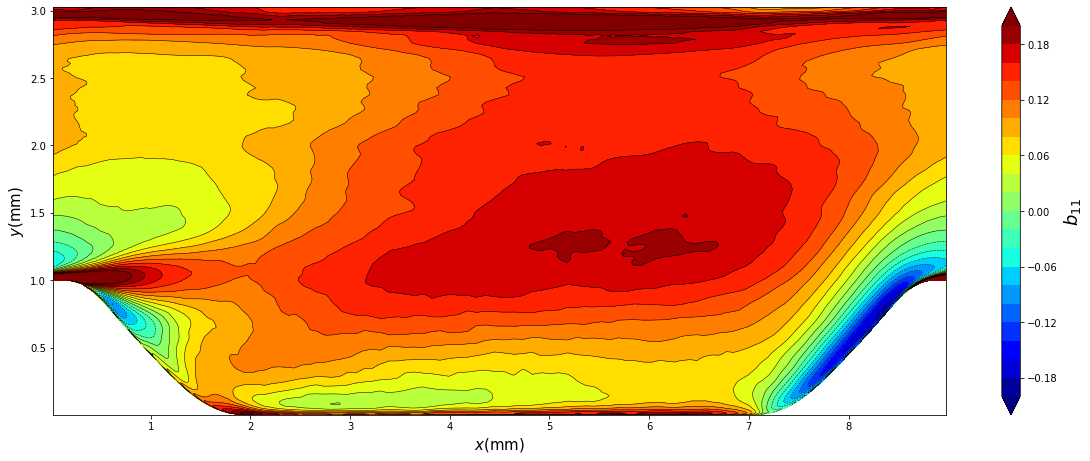

0

In [8]:
plot_contour_2(x_RANS,y_RANS,140,150,b_11_inter,'$b_{11}$',21,-0.2,0.2)

In [9]:
b_all = np.column_stack((b_11_inter,b_12_inter,b_13_inter,b_22_inter,b_23_inter,b_33_inter))
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/Anisotropy_Tensors_LES_NASA.npy",b_all)

In [17]:
b_11_part = b_11_inter[0:(140*100)]
b_12_part = b_12_inter[0:(140*100)]
b_13_part = b_13_inter[0:(140*100)]
b_22_part = b_22_inter[0:(140*100)]
b_23_part = b_23_inter[0:(140*100)]
b_33_part = b_33_inter[0:(140*100)]
b_all = np.column_stack((b_11_part,b_12_part,b_13_part,b_22_part,b_23_part,b_33_part))
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/Anisotropy_Tensors_LES_NASA.npy",b_all)

In [10]:
b_11_inter

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
b_all[1]

array([ 0.21200002, -0.00613489,  0.        , -0.332439  ,  0.        ,
        0.12043898])